## Quick Start

This notebook assumes you have followed the steps to download the Excalibur package onto your local machine. If you haven't, please visit the [Installation](https://excalibur-alpha.readthedocs.io/en/latest/content/installation.html) page.

On this page, we run through the basic features of Excalibur. We demonstrate how to download a line list, compute a cross section, and plot the result. Further tutorials are more nuanced and illustrate how to play around with various parameters. The Run.py file is where the user will usually interact with Excalibur. Please make sure this file is in the same directory as the 'excalibur' folder in your Excalibur package (if you followed the instructions on the [Installation](https://excalibur-alpha.readthedocs.io/en/latest/content/installation.html) page, this will already be the case).

### Downloading a Line List

Suppose we want to download the line list for CO from ExoMol. Start by opening up the Run.py file and making sure it is empty; all of the following code will be written in that file. All of the major end-user functions are contained in the `core.py` file. Thus, to summon the line list, we import the `summon` function `from excalibur.core`. We then specify the species and database. Finally, call the `summon` function, and the line list is downloaded!

#### Example: Downloading the CO line list from ExoMol

In [1]:
from excalibur.core import summon

species = 'CO'
database = 'ExoMol'

# Download line list
summon(database=database, species = species)


 ***** Downloading requested data from ExoMol. You have chosen the following parameters: ***** 

Molecule: CO 
Isotopologue: 12C-16O 
Line List: Li2015

Starting by downloading the .broad, .pf, and .states files...
Fetched the broadening coefficients, partition functions, and energy levels.
Now downloading the Li2015 line list...



100%|█████████████████████████████████████| 1.40M/1.40M [00:00<00:00, 1.88MiB/s]



Converting this .trans file to HDF to save storage space...
This file took 0.1 seconds to reformat to HDF.



100%|██████████████████████████████████████| 63.5k/63.5k [00:00<00:00, 310kiB/s]


Converting this .trans file to HDF to save storage space...
This file took 0.0 seconds to reformat to HDF.

Line list ready.



The output displayed after calling this function has some pertinent details for the user. The default isotopologue and line list has been chosen (the user can specify others if desired) and is shown on top with the molecule. Other data important for cross section computations, notably broadening coefficients, partition functions, and energy levels, is downloaded now for convenience. Finally, we see that the line list itself consists of two files, which ExoMol chooses to store in a .trans extension. Both of these .trans files are downloaded, and reformatted by Excalibur to an HDF5 file type, to save storage space. 

Excalibur automatically creates an 'input' folder at the same directory level as the Run.py file. This input folder will contain the CO data we have just downloaded.

### Computing a Cross Section

We should now have all the data needed to compute our first cross section for CO! Import the `compute_cross_section` function, again from `excalibur.core`. This time, the user must specify at least five parameters, as opposed to the two for the `summon` function. As before, Excalibur needs to know the `species` and `database` from which the line list was downloaded. Cross sections are computed at a certain pressure and temperature, so the user must specify the values `P` and `T` as well. Lastly, Excalibur needs to know the top directory level containing downloaded line lists. If no file structure has been changed by the user since the start of the tutorial, this will just be equivalent to setting `input_directory = './input/'`. This culminates in the code presented below.

#### Example: Computing CO Cross Section

In [2]:
from excalibur.core import compute_cross_section

P = 1  # Pressure in bars
T = 1000  # Temperature in Kelvin
input_directory = './input/' # Top level directory containing line lists

compute_cross_section(species = species, database = database, temperature = T, input_dir = input_directory, 
                      pressure = P)



Beginning cross-section computations...
Loading ExoMol format
Loading partition function


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Pre-computing Voigt profiles...
Voigt profiles computed in 5.9012720419996185 s
Pre-computation steps complete
Generating cross section for CO at P = 1 bar, T = 1000 K
Computing transitions from Li2015.h5 | 0.0% complete
Completed 125496 transitions in 6.77075275000243 s
Computing transitions from E2.h5 | 50.0% complete
Completed 6474 transitions in 0.20465150001109578 s
Calculation complete!
Completed 131970 transitions in 7.03282766600023 s

Total runtime: 17.243233458008035 s


As you can see, the console will display important information about how the computation is progressing. The Li2015 line list for CO is quite small, less than 1 MB (corresponding to $\approx$ 100,000 transitions), so the total cross section takes only 12 seconds to produce. Larger line lists, like the POKAZATEL line list for H2O, can be on the order of tens of gigabytes ($\approx$ 6 billion transitions), and lead to cross sections that take around 24 hours to compute.

And that's it! You'll notice that an 'output' folder has been created, at the same directory level as the Run.py file and the 'input' folder. Navigate through the output folder (by clicking on the molecule, database, etc.) to find our CO cross section in a .txt file titled 'CO_T1000K_log_P0.0_H2-He_sigma.txt'. This is aptly named according to the parameters with which the cross section was computed.

The cross section file consists of two columns; the first is the wavenumber (in cm $^{-1}$) and the second is the absorption cross section (in cm $^{2}$). Some users may want to stop here, and just read in the cross section calculations for their own research. A function to read the cross section, `read_cross_section_file`, is provided and demonstrated below. Other users may want to plot the cross section for a more visually appealing final product. We show this as well in the next section.

### Reading in and Plotting a Cross Section

This section contains a basic introduction on how to use the plotting routine we've provided. For more complicated plots, like overplotting multiple cross sections on the same plot, see any of the other tutorials provided (like [this](https://excalibur-alpha.readthedocs.io/en/latest/content/notebooks/cross_section_grid.html) one).

#### Example: Plotting CO Cross Section

First, we want to return the wavenumber and absorption from the output cross section file. To do this, import the `read_cross_section_file` from `plot.py`. This function requires the `species` and `database` as parameters, as well as the `filename` of the output file. We assign `nu` (the wavenumber) and `sigma` (the absorption cross section) to the return values.

In [5]:
from excalibur.plot import read_cross_section_file

# Read in previously computed cross section file
nu, sigma  = read_cross_section_file(species = species, database = database, filename = 'CO_T1000K_log_P0.0_H2-He_sigma.txt')

We'll also need to import `plot_cross_section` and `cross_section_collection`. 

In [6]:
# Import relevant functions
from excalibur.plot import cross_section_collection, plot_cross_section

Before we use `plot_cross_section`, we want to add our newly computed cross section to a collection. This extra step comes in especially handy for plotting multiple cross sections to one graph, but is still required even for one cross section. To do this, we call the `cross_section_collection` function, and pass in as parameters our return values `nu` and `sigma`.

In [7]:
# Add to collection
cross_sections = cross_section_collection(nu, sigma)

Then, to plot, call the `plot_cross_section` function. It requires at least 3 parameters: the cross section `collection`, an array of `labels` for each cross_section that is to be plotted (in this case we have added just one label), and a `filename` to save the plot to. Here, we have chosen a filename that describes exactly what cross section was plotted - the CO cross section, from the Li2015 line list, at a temperature of 1000 K and pressure of 1 bar. 


Plotting complete.


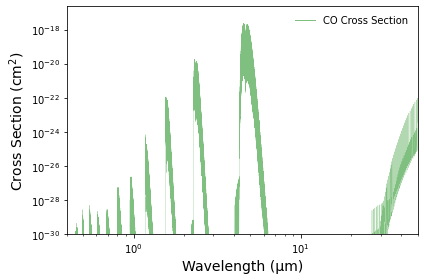

In [8]:
# Plot cross section
spectrum = plot_cross_section(collection = cross_sections, labels = ['CO Cross Section'], filename = 'CO_Li2015_T1000_P1')

In a newly created 'plots' folder, which is at the same directory level as 'input' and 'output', you'll see the plot. 